In [98]:
%matplotlib inline
import numpy as np
import torch
from torch.utils.serialization import load_lua
import os
import scipy.io as sio
import cv2
import math
from matplotlib import pyplot as plt

from PIL import Image
import PIL

from math import cos, sin, tan

In [99]:
def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180

    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

In [100]:
DATA_DIR = '/Data/nruiz9/data/facial_landmarks/biwi/'

[[ 0.999593    0.0057449  -0.027935  ]
 [ 0.00145761  0.96793     0.251214  ]
 [ 0.0284823  -0.251153    0.967528  ]] [   33.8871   172.045   1144.61  ]
-1.6321367145 14.5517888999 0.0835488463624


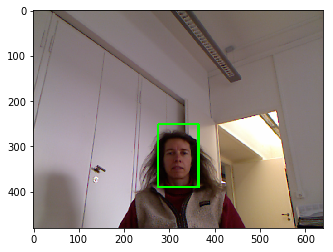

In [110]:
img_name = '18/frame_00195_rgb.png'
img_path = os.path.join(DATA_DIR, 'data/hpdb/' + img_name + '_rgb.png')
pose_path = os.path.join(DATA_DIR, 'data/hpdb/' + img_name + '_pose.txt')
img_name_list = img_name.split('/')
bbox_path = os.path.join(DATA_DIR, 'data/hpdb/' + img_name_list[0] + '/dockerface-' + img_name_list[1] + '_rgb.txt')


# Load bounding box
bbox = open(bbox_path, 'r')
line = bbox.readline().split(' ')
x_min, y_min, x_max, y_max = [float(line[1]), float(line[2]), float(line[3]), float(line[4])]

# Loosely crop face
k = 0.35
x_min -= 0.6 * k * abs(x_max - x_min)
y_min -= k * abs(y_max - y_min)
x_max += 0.6 * k * abs(x_max - x_min)
y_max += 0.6 * k * abs(y_max - y_min)
bbox.close()

img = cv2.imread(img_path)

pose_annot = open(pose_path, 'r')
R = []
for line in pose_annot:
    line = line.strip('\n').split(' ')
    l = []
    if line[0] != '':            
        for nb in line:
            if nb == '':
                continue
            l.append(float(nb))
        R.append(l)

R = np.array(R)
T = R[3,:]
R = R[:3,:]
print R, T
pose_annot.close()

roll = np.arctan2(R[1][0], R[0][0]) * 180 / np.pi
yaw = np.arctan2(-R[2][0], np.sqrt(R[2][1] ** 2 + R[2][2] ** 2)) * 180 / np.pi
pitch = -np.arctan2(R[2][1], R[2][2]) * 180 / np.pi

print yaw, pitch, roll

plot_pose_cube(img, yaw, pitch, roll, int((x_max + x_min)/2), int((y_max + y_min)/2), size = 100)
cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,255,0), 4)

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(img)
plt.show()

In [97]:
import glob
image_list = glob.glob('../data/biwi/data/hpdb/01/*.png')
image_list.extend(glob.glob('../data/biwi/data/hpdb/01/*.txt'))
print image_list

['../data/biwi/data/hpdb/01/frame_00202_rgb.png', '../data/biwi/data/hpdb/01/frame_00329_rgb.png', '../data/biwi/data/hpdb/01/frame_00371_rgb.png', '../data/biwi/data/hpdb/01/frame_00165_rgb.png', '../data/biwi/data/hpdb/01/frame_00042_rgb.png', '../data/biwi/data/hpdb/01/frame_00286_rgb.png', '../data/biwi/data/hpdb/01/frame_00196_rgb.png', '../data/biwi/data/hpdb/01/frame_00246_rgb.png', '../data/biwi/data/hpdb/01/frame_00436_rgb.png', '../data/biwi/data/hpdb/01/frame_00281_rgb.png', '../data/biwi/data/hpdb/01/frame_00453_rgb.png', '../data/biwi/data/hpdb/01/frame_00478_rgb.png', '../data/biwi/data/hpdb/01/frame_00231_rgb.png', '../data/biwi/data/hpdb/01/frame_00038_rgb.png', '../data/biwi/data/hpdb/01/frame_00337_rgb.png', '../data/biwi/data/hpdb/01/frame_00101_rgb.png', '../data/biwi/data/hpdb/01/frame_00341_rgb.png', '../data/biwi/data/hpdb/01/frame_00055_rgb.png', '../data/biwi/data/hpdb/01/frame_00128_rgb.png', '../data/biwi/data/hpdb/01/frame_00278_rgb.png', '../data/biwi/data/